# Sudeste Module 3 Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

It is discouraged to rename the `notebook.ipynb` for this particular task.

## Version Control Log
Latest Change of Version: Version 1.


**

#### Version 1.0.0 | May 04, 2024  

**Author:** its-very-berry-dark  

Changes:
- Edited the structure of the template and imported modules such as tensorflow, pandas, scikit-learn, and others 


**  


##### Version 1.1.0 | May 10, 2024
**Author(s):** EinsAguaviva, its-very-berry-dark

Changes: 
- Added the draft for the Exploratory Data Analysis on the dataset
- Included the cleaned dataset


**

##### Version 1.2.0 | May 10, 2024
**Author:** its-very-berry-dark

Changes: 
- Rewrote the ARIMA Model
- Edited Deep Learning Model (Version 1)
- Merged branch feature 

**

##### Version 1.3.0 | May 10, 2024
**Author:** its-very-berry-dark, EinsAguaviva

Changes:
- Added version control details
- Edited Deep Learning Model (Version 2)
- Added more descriptions 


** 

***

### <span style="color:Orange;">  Table of Contents: </span>

I.   [Executive Summary](#summary)

II.  [Objective](#objective)

III. [Data Processing](#dataprocess)

IV.  [Visualizations and EDA](#eda)

V.   [ARIMA Model](#arima)

VI.  [Deep Learning Model](#dl)
  
VII. [Comparison](#comparison)

VIII.[Conclusion and Recommendations](#conclusion)

***

## <span style="color:Orange;"> I. Executive Summary </span>  <a name="summary"></a>
We investigated the performance of two different approaches in this comparative study of temperature prediction models for Sacramento: **a deep learning Long Short-Term Memory (LSTM) model** and an **Autoregressive Integrated Moving Average (ARIMA) model**. The first model we used was an ARIMA(1, 1, 1) model with seasonal parameters (1, 1, 1, 9), selected by looking at the value of the Akaike Information Criterion (AIC), which was the lowest. Every model coefficient had a statistically significant p-value, indicating that the model fit the data satisfactorily. The ARIMA model was validated using real temperature data for the final seven days of September 2016. The results showed an MSE of 1.8369 and an RMSE of 1.3553 for the model.   

For temperature prediction, we put an LSTM model into practice and evaluated its effectiveness against the ARIMA model. Two LSTM layers with dropout regularisation made up the LSTM model architecture, which was then followed by a Dense layer. The training and validation loss curves show that convergence occurred after 20 epochs of training the model with the Adam optimizer and mean squared error loss. When the LSTM model was evaluated using RMSE on training and testing data, the results showed that the model performed moderately, with RMSE values of 4.5703 and 5.5288, respectively.

Upon visual inspection, it was possible to discern a reasonable alignment between the expected and actual temperatures for the final seven days of September 2016 across both models. On the other hand, the ARIMA model outperformed the LSTM model in terms of prediction accuracy, as evidenced by its reduced RMSE. Still, more optimisation and fine-tuning of the LSTM model may improve its performance. The decision between the ARIMA and LSTM models ultimately comes down to particular needs and circumstances. Both models have advantages and disadvantages that should be taken into account for temperature prediction tasks in Sacramento.

## <span style="color:Orange;"> II. Objective </span>  <a name="objective"></a>  
The purpose of this dataset is to compare which among the two models, Autoregressive Integrated Model (ARIMA) and Deep Learning model using LSTM, performs better in terms of <i>Prediction</I> and <i>classification</i>. This notebook delves into the models' outcomes, documenting and charting their mean squared error (MSE) along with the models' root mean squared error (RMSE). Through this comparison, it makes it possible to determine which model is more efficient, quicker, and accurate. This detailed evaluation helps us understand each method's good and bad points, making it easier to choose the best model for future use or for making improvements.

## <span style="color:Orange;"> III. Data Processing </span>  <a name="dataprocess"></a>  

Importing Modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import warnings
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from datetime import datetime

pd.set_option('display.max_columns', 40)   # displays max columns of the DataFrame 

### Processing the data
In this dataset, the group opt to only take the latest 30 days in the dataset as the dataset are divided into hours instead of day. In this case, the dataset is filtered, only taking the rows that are in the month of September 2016.

In [2]:
# Chunking the dataset for faster processing of data
filepath = "C:/Users/User/Downloads/sudeste.csv"
chunk_size = 30000 
df = pd.DataFrame()

# Iterate over chunks of the file and process each chunk
for chunk in pd.read_csv(filepath, parse_dates=['mdct', 'date'], chunksize=chunk_size):
    filtered_chunk = chunk[chunk['date'] >= '2016-01-01']
    df = pd.concat([df, filtered_chunk])

In [6]:
# Only showing the columns with null values
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]  
if not missing_columns.empty:
    print('Columns with missing values:')
    print(missing_columns)
else:
    print('No missing values in any columns.')

Columns with missing values:
prcp    668060
gbrd    328121
temp        11
dewp        64
tmax        10
dmax        41
tmin         5
dmin       103
wdsp     75367
gust     25152
dtype: int64


In [3]:
# Filling missing values with the average of the previous and next non-null values
# This is done ONLY to the relevant columns

df['prcp'] = df['prcp'].fillna((df['prcp'].ffill() + df['prcp'].bfill()) / 2)
df['wdsp'] = df['wdsp'].fillna((df['wdsp'].ffill() + df['wdsp'].bfill()) / 2)
df['temp'] = df['temp'].fillna((df['temp'].ffill() + df['temp'].bfill()) / 2) 

## <span style="color:Orange;"> IV. Visualizations and EDA </span>  <a name="eda"></a>  

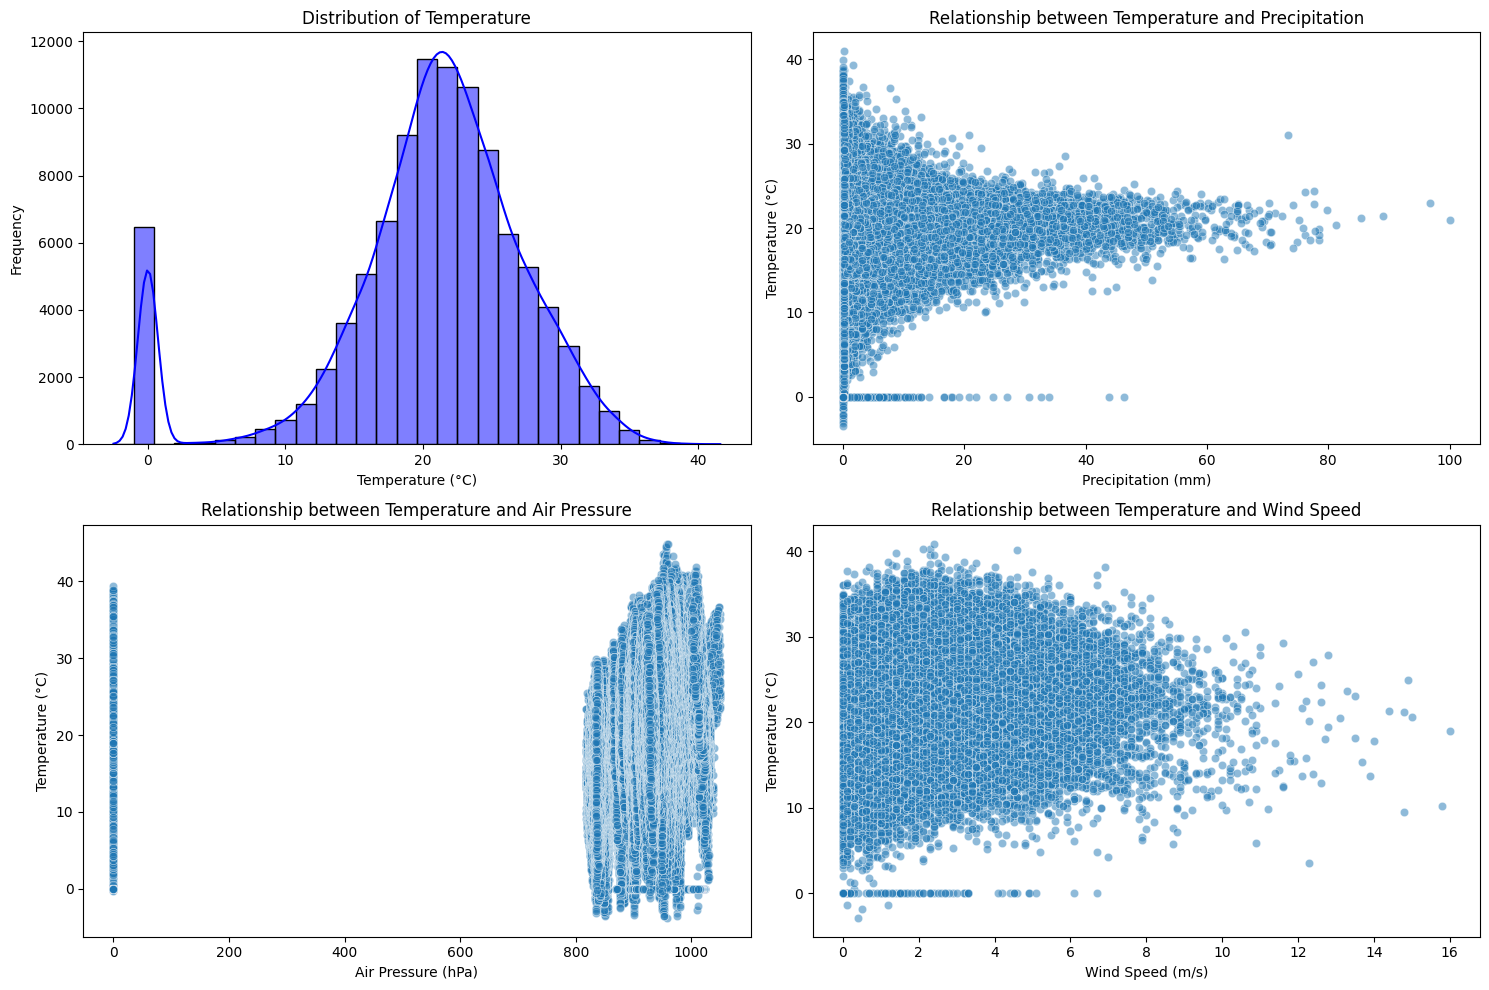

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Visualize the distribution of temperature
sns.histplot(df['temp'].sample(n=100000), bins=30, kde=True, color='blue', ax=axes[0, 0])  # Sample a subset of data for visualization
axes[0, 0].set_title('Distribution of Temperature')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')

# Relationship between Temperature and Precipitation
sns.scatterplot(x='prcp', y='temp', data=df, alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Relationship between Temperature and Precipitation')
axes[0, 1].set_xlabel('Precipitation (mm)')
axes[0, 1].set_ylabel('Temperature (°C)')

# Relationship between Temperature and Air Pressure
sns.scatterplot(x='stp', y='temp', data=df, alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Relationship between Temperature and Air Pressure')
axes[1, 0].set_xlabel('Air Pressure (hPa)')
axes[1, 0].set_ylabel('Temperature (°C)')

# Relationship between Temperature and Wind Speed
sns.scatterplot(x='wdsp', y='temp', data=df.sample(n=100000), alpha=0.5, ax=axes[1, 1])  # Sample a subset of data for visualization
axes[1, 1].set_title('Relationship between Temperature and Wind Speed')
axes[1, 1].set_xlabel('Wind Speed (m/s)')
axes[1, 1].set_ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

**The first graph** shows the distribution of temperature. The x-axis represents temperature in degrees Celsius (°C), and the y-axis represents frequency. The graph shows that the most frequent temperatures fall between 10°C and 20°C.

**The second graph** shows the relationship between temperature and precipitation. The x-axis represents temperature in degrees Celsius (°C), and the y-axis represents precipitation in millimeters (mm). The graph shows that there is a positive correlation between temperature and precipitation. This means that as the temperature increases, the precipitation also increases.

**The third graph** shows the relationship between temperature and air pressure. The x-axis represents temperature in degrees Celsius (°C), and the y-axis represents air pressure in hectopascals (hPa). The graph shows that there is an inverse correlation between temperature and air pressure. This means that as the temperature increases, the air pressure decreases.

**The fourth graph** shows the relationship between temperature and wind speed. The x-axis represents temperature in degrees Celsius (°C), and the y-axis represents wind speed in meters per second (m/s). The graph shows that there is a weak positive correlation between temperature and wind speed. This means that as the temperature increases, the wind speed also increases, but the correlation is weak.`

In [20]:
# List of all the weather stations/cities
df['wsnm'].unique()

array(['SÃO GONÇALO', 'VITÓRIA', 'SANTA TERESA', 'LINHARES',
       'ALFREDO CHAVES', 'SÃO MATEUS', 'ALEGRE', 'PRES. KENNEDY',
       'NOVA VENECIA', 'AFONSO CLAUDIO', 'BARBACENA', 'ARAXÁ',
       'MONTES CLAROS', 'UBERLÂNDIA', 'ALMENARA', 'MONTE VERDE', 'VIÇOSA',
       'TIMÓTEO', 'ITUIUTABA', 'OURO BRANCO', 'S.J.DEL REI', 'VARGINHA',
       'PASSOS', 'MURIAÉ', 'JUÍZ DE FORA', 'CAMPINA VERDE',
       'CONC. DAS ALAGOAS', 'BELO HOR. (PAMPULHA)', 'SERRA DOS AIMORES',
       'PATROCÍNIO', 'FORMIGA', 'SACRAMENTO', 'MONTALVANIA',
       'TEÓFILO OTONI', 'TRÊS MARIAS', 'PASSA QUATRO', 'CALDAS',
       'MARIA DA FÉ', 'GOVERNADOR VALADARES', 'GUANHÃES', 'AIMORES',
       'FLORESTAL', 'DORES DO INDAIÁ', 'DIAMANTINA', 'CURVELO',
       'MOCAMBINHO', 'MANTENA', 'CAPELINHA', 'UNAI', 'ESPINOSA',
       'BURITIS', 'PIRAPORA', 'GUARDA-MOR', 'SÃO ROMÃO', 'CHAPADA GAÚCHA',
       'ÁGUAS VERMELHAS', 'ITAOBIM', 'RIO PARDO DE MINAS', 'SALINAS',
       'JOÃO PINHEIRO', 'CARATINGA', 'IBIRITÈ (ROLA MOÇA)', 

Since there are numerous cities and it would not be plausible to combine them due to different locations. The group intends to plotting the time series using SACRAMENTO city (with weather id station #333).

In [4]:
chosen_city = df[df["wsnm"] == "SACRAMENTO"]
chosen_city.reset_index(drop=True, inplace=True)

In [22]:
chosen_city.head(3)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,yr,mo,da,hr,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 00:00:00,2016-01-01,2016,1,1,0,2.5,912.2,912.2,911.6,52.703,22.3,18.9,23.4,18.9,22.3,17.7,81.0,81.0,70.0,1.1,49.0,3.4
1,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 01:00:00,2016-01-01,2016,1,1,1,2.5,912.9,912.9,912.2,52.703,22.3,18.8,22.5,19.1,22.2,18.7,80.0,82.0,80.0,0.2,139.0,1.5
2,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 02:00:00,2016-01-01,2016,1,1,2,2.5,912.8,913.0,912.8,52.703,22.1,18.7,22.5,18.8,22.1,18.3,81.0,81.0,78.0,0.7,184.0,1.4


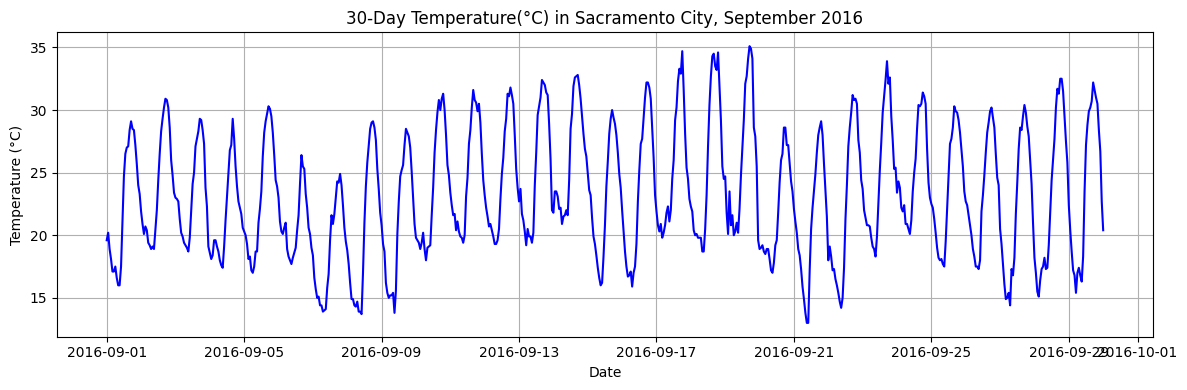

In [7]:
# Creating a time series plot of 30 days of temperature
# Filter the DataFrame to include only dates from August 1 to the last day of August
sept_data = chosen_city[(chosen_city['mdct'] >= '2016-09-01') & (chosen_city['mdct'] <= '2016-09-30')]

plt.figure(figsize=(12, 4))
plt.plot(sept_data['mdct'], sept_data['temp'], color='blue', linestyle='-')
plt.title('30-Day Temperature(°C) in Sacramento City, September 2016')                             
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

September 2016, Sacramento City, California, **Average daily temperature** is displayed on the graph. September 1, 2016, to September 30, 2016 is the date range displayed on the x-axis. Degree Celsius (°C) is displayed on the y-axis as the temperature.A high of about 32°C and a low of about 15°C are seen for the average daily temperature throughout the month. The average monthly temperature appears to be about 25°C, although it is hard to tell from this graph.

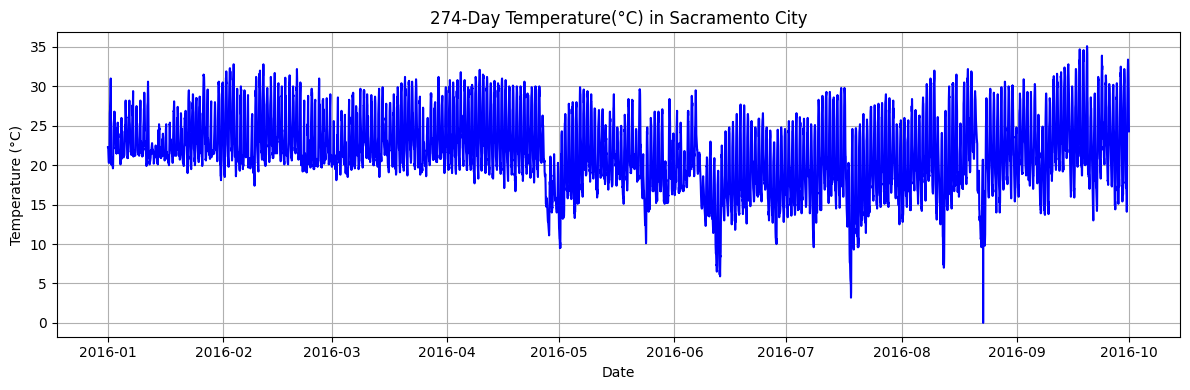

In [25]:
# Create a time series plot of 9 months of temperature
plt.figure(figsize=(12, 4))
plt.plot(chosen_city['mdct'], chosen_city['temp'], color='blue', linestyle='-')
plt.title('274-Day Temperature(°C) in Sacramento City')                                   #274 days as the year 2016 is a leap year
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

The temperature average for **Sacramento City, California** in 2016 is seen on the graph. The graph indicates that Sacramento has a warm Mediterranean climate, with warm, dry summers and moderate, wet winters. The x-axis displays the month, and the y-axis displays the temperature in degrees Celsius (°C). The average temperature is around 10°C (50°F) in December and January and reaches its maximum in July and August, when it is approximately 27°C (80°F).

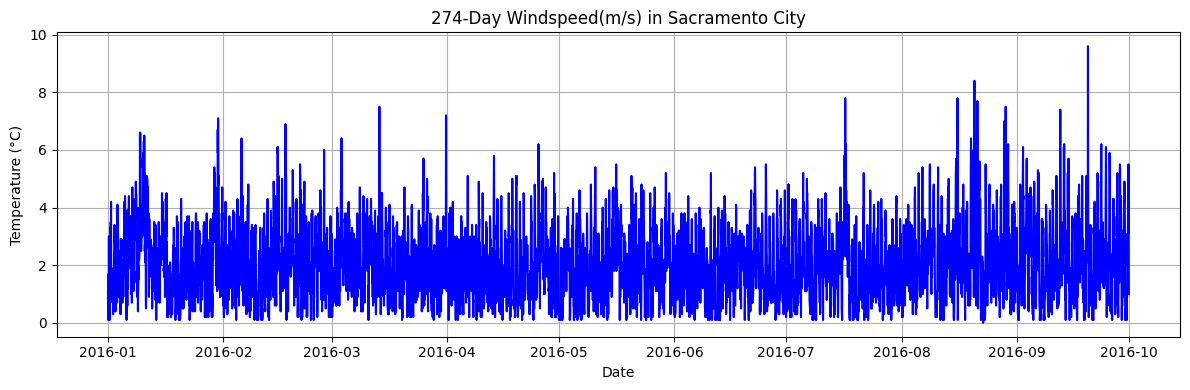

In [110]:
# Create a time series plot of temperature
plt.figure(figsize=(12, 4))
plt.plot(chosen_city['mdct'], chosen_city['wdsp'], color='blue', linestyle='-')
plt.title('274-Day Windspeed(m/s) in Sacramento City')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

**“274-Day Windspeed(m/s) in Sacramento City,”** This shows the windspeed in meters per second over a period from January to October 2016. The blue vertical lines represent daily windspeeds, with taller lines indicating higher speeds.

## <span style="color:Orange;"> V. ARIMA Model </span>  <a name="arima"></a>  
In this section, we'll build an ARIMA (AutoRegressive Integrated Moving Average) model to forecast temperature based on historical weather data. We'll start by preparing the data for modeling, then train the ARIMA model, and finally evaluate its performance. First, the group will find the best values for the ARIMA model by exploring different combinations in parameters (p, d, q).

In [7]:
p = d = q = range(0,2)

# Generating all different combinations of parameter
pdq = list(itertools.product(p, d, q))

# Generating all different combinations
seasonal_pdq = [(x[0], x[1], x[2], 9) for x in list(itertools.product(p, d, q))]

### Finding the best parameter
The group will use the Akaike Information Criterion value (AIC), which measures how well a model fits the data. The group finds the model that yields the lowest AIC value.

In [5]:
sacramento_temp = chosen_city[['mdct', 'temp']]
sacramento_temp.set_index('mdct', inplace=True)

In [9]:
sacramento_temp

,temp
mdct,
2016-01-01 00:00:00,22.3
2016-01-01 01:00:00,22.3
2016-01-01 02:00:00,22.1
2016-01-01 03:00:00,21.5
2016-01-01 04:00:00,20.8
...,...
2016-09-30 19:00:00,31.6
2016-09-30 20:00:00,31.2
2016-09-30 21:00:00,29.3


In [8]:
warnings.filterwarnings('ignore')     # remove the warnings

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(sacramento_temp, order=param, 
            seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

            results = model.fit()
            print(f'ARIMA{param} * {param_seasonal}9 - AIC:{results.aic}')          # 9 since there are 9 months involved
        except:
            continue

ARIMA(0, 0, 0) * (0, 0, 0, 9)9 - AIC:59493.49768008627
ARIMA(0, 0, 0) * (0, 0, 1, 9)9 - AIC:52606.465761521205
ARIMA(0, 0, 0) * (0, 1, 0, 9)9 - AIC:44302.0444574341
ARIMA(0, 0, 0) * (0, 1, 1, 9)9 - AIC:38240.65893488921
ARIMA(0, 0, 0) * (1, 0, 0, 9)9 - AIC:44147.67445234129
ARIMA(0, 0, 0) * (1, 0, 1, 9)9 - AIC:38304.538554579936
ARIMA(0, 0, 0) * (1, 1, 0, 9)9 - AIC:40637.4779897821
ARIMA(0, 0, 0) * (1, 1, 1, 9)9 - AIC:37277.32148895976
ARIMA(0, 0, 1) * (0, 0, 0, 9)9 - AIC:50774.15739850007
ARIMA(0, 0, 1) * (0, 0, 1, 9)9 - AIC:45112.96479702018
ARIMA(0, 0, 1) * (0, 1, 0, 9)9 - AIC:37248.11106045674
ARIMA(0, 0, 1) * (0, 1, 1, 9)9 - AIC:31250.971255805245
ARIMA(0, 0, 1) * (1, 0, 0, 9)9 - AIC:37071.40300794167
ARIMA(0, 0, 1) * (1, 0, 1, 9)9 - AIC:31305.953868041044
ARIMA(0, 0, 1) * (1, 1, 0, 9)9 - AIC:33706.15716790526
ARIMA(0, 0, 1) * (1, 1, 1, 9)9 - AIC:30471.66923802066
ARIMA(0, 1, 0) * (0, 0, 0, 9)9 - AIC:23891.865630865766
ARIMA(0, 1, 0) * (0, 0, 1, 9)9 - AIC:23117.961132224664
ARIMA(

In [84]:
warnings.filterwarnings('ignore')     # remove the warnings

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(sacramento_temp, order=param, 
            seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

            results = model.fit()
            print(f'ARIMA{param} * {param_seasonal}9 - AIC:{results.aic}')          # 9 since there are 9 months involved
        except:
            continue

ARIMA(0, 0, 0) * (0, 0, 0, 9)9 - AIC:59493.49768008627
ARIMA(0, 0, 0) * (0, 0, 1, 9)9 - AIC:52606.465761521205
ARIMA(0, 0, 0) * (0, 1, 0, 9)9 - AIC:44302.0444574341
ARIMA(0, 0, 0) * (0, 1, 1, 9)9 - AIC:38240.65893488921
ARIMA(0, 0, 0) * (1, 0, 0, 9)9 - AIC:44147.67445234129
ARIMA(0, 0, 0) * (1, 0, 1, 9)9 - AIC:38304.538554579936
ARIMA(0, 0, 0) * (1, 1, 0, 9)9 - AIC:40637.4779897821
ARIMA(0, 0, 0) * (1, 1, 1, 9)9 - AIC:37277.32148895976
ARIMA(0, 0, 1) * (0, 0, 0, 9)9 - AIC:50774.15739850007
ARIMA(0, 0, 1) * (0, 0, 1, 9)9 - AIC:45112.96479702018
ARIMA(0, 0, 1) * (0, 1, 0, 9)9 - AIC:37248.11106045674
ARIMA(0, 0, 1) * (0, 1, 1, 9)9 - AIC:31250.971255805245
ARIMA(0, 0, 1) * (1, 0, 0, 9)9 - AIC:37071.40300794167
ARIMA(0, 0, 1) * (1, 0, 1, 9)9 - AIC:31305.953868041044
ARIMA(0, 0, 1) * (1, 1, 0, 9)9 - AIC:33706.15716790526
ARIMA(0, 0, 1) * (1, 1, 1, 9)9 - AIC:30471.66923802066
ARIMA(0, 1, 0) * (0, 0, 0, 9)9 - AIC:23891.865630865766
ARIMA(0, 1, 0) * (0, 0, 1, 9)9 - AIC:23117.961132224664
ARIMA(

#### Fitting the model to data with the best parameters
The last AIC line has the lowest AIC value (22023.022) out of all the listed parameters. Thus, we will take `ARIMA(1, 1, 1), (1, 1, 1, 9)`

In [9]:
best_model = sm.tsa.statespace.SARIMAX(sacramento_temp, order=(1,1,1), seasonal_order=(1, 1, 1, 9),
                                       enforce_stationarity=False, enforce_invertibility=False)

results = best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6294,0.019,32.369,0.000,0.591,0.668
ma.L1,-0.2547,0.018,-13.833,0.000,-0.291,-0.219
ar.S.L9,-0.1402,0.011,-12.840,0.000,-0.162,-0.119
ma.S.L9,-1.0011,0.004,-249.245,0.000,-1.009,-0.993
sigma2,1.6659,0.012,143.990,0.000,1.643,1.689


In [212]:
best_model = sm.tsa.statespace.SARIMAX(sacramento_temp, order=(1,1,1), seasonal_order=(1, 1, 1, 9),
                                       enforce_stationarity=False, enforce_invertibility=False)

results = best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6294,0.019,32.369,0.000,0.591,0.668
ma.L1,-0.2547,0.018,-13.833,0.000,-0.291,-0.219
ar.S.L9,-0.1402,0.011,-12.840,0.000,-0.162,-0.119
ma.S.L9,-1.0011,0.004,-249.245,0.000,-1.009,-0.993
sigma2,1.6659,0.012,143.990,0.000,1.643,1.689


Each weight of the models has a p-value (P>|z|) less than 0.05, that is why we'll retain the models.

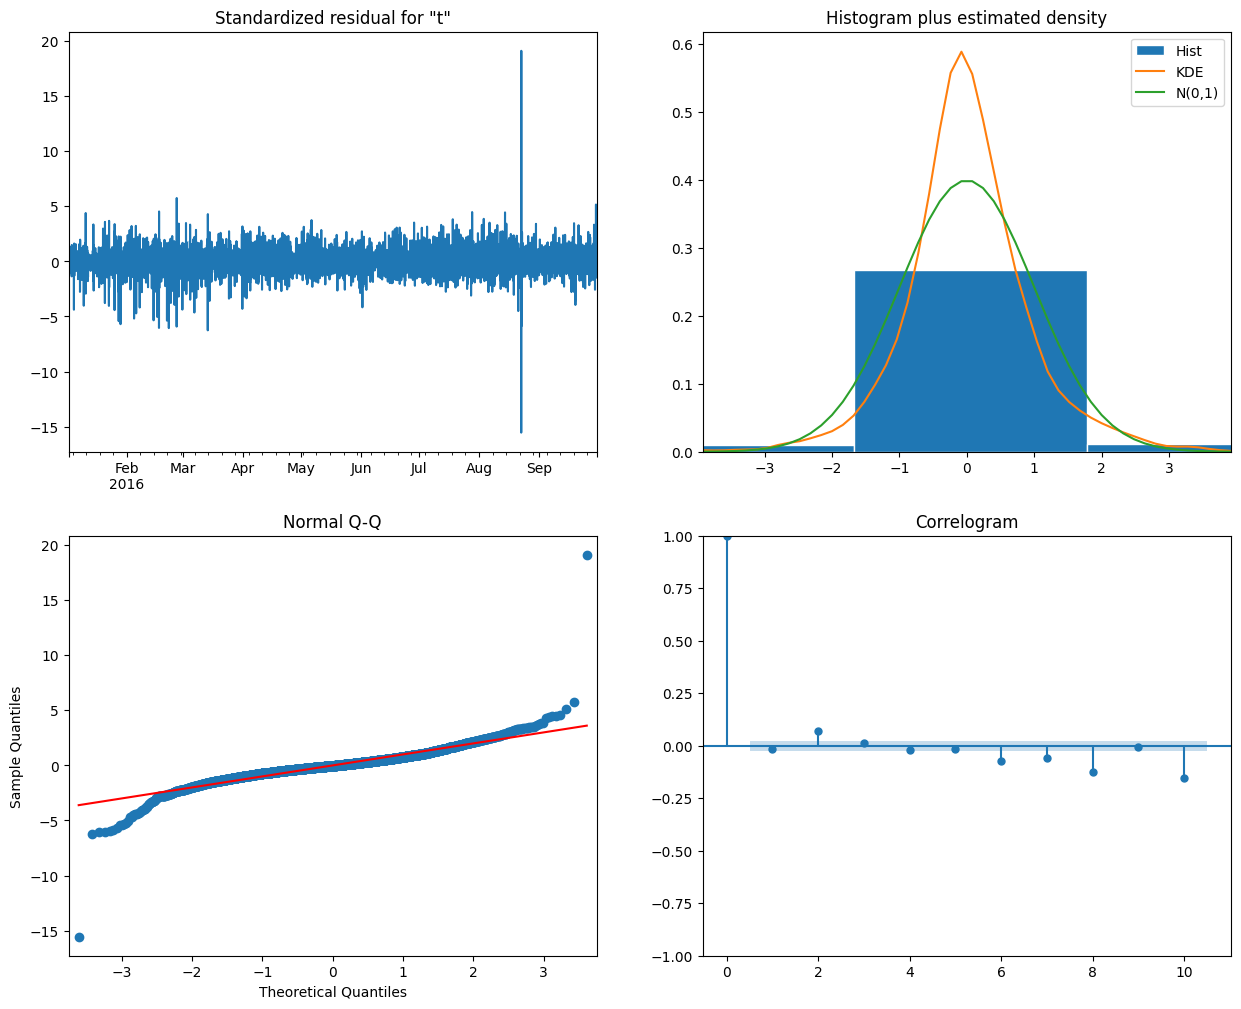

In [10]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

### Validating Forecast
First, we will determine the accuracy and errors of the actual and predicted values of a present data by comparing the actual and predicted values of the last 7 days in September 2016. Later on, the created model will be used to forecast the unknown data (since the dataset is only up until September 20, 2016). The created model will predict the temperature of the incoming 7 days starting from October 01, 2016.

In [11]:
# Confidence Interval of the dataset
pred = results.get_prediction(start=pd.to_datetime('2016-09-24 00:00:00'), dynamic=False)
pred_conf_i = pred.conf_int()
pred_conf_i

,lower temp,upper temp
2016-09-24 00:00:00,22.454499,27.521080
2016-09-24 01:00:00,20.049384,25.115964
2016-09-24 02:00:00,21.803316,26.869893
2016-09-24 03:00:00,21.350148,26.416725
2016-09-24 04:00:00,18.886873,23.953451
...,...,...
2016-09-30 19:00:00,29.835919,34.902428
2016-09-30 20:00:00,27.671428,32.737935
2016-09-30 21:00:00,28.115188,33.181695
2016-09-30 22:00:00,26.025403,31.091910


#### Actual vs Predicted Values
Predicting the values on the last 7 days of September. <span style="color:Red;"> temp </span> is the <span style="color:Red;">actual temperature </span>, while <span style="color:Blue;"> Pred_temp </span> is the <span style="color:Blue;">predicted temperature </span>. This step evaluates the mean squared error of the model.

In [12]:
y_forecasted = pred.predicted_mean
y_truth = sacramento_temp['2016-09-24 00:00:00':]
y_truth['Pred_temp'] = y_forecasted
y_truth

,temp,Pred_temp
mdct,,
2016-09-24 00:00:00,23.4,24.987789
2016-09-24 01:00:00,24.3,22.582674
2016-09-24 02:00:00,23.8,24.336605
2016-09-24 03:00:00,22.2,23.883437
2016-09-24 04:00:00,21.9,21.420162
...,...,...
2016-09-30 19:00:00,31.6,32.369174
2016-09-30 20:00:00,31.2,30.204682
2016-09-30 21:00:00,29.3,30.648442


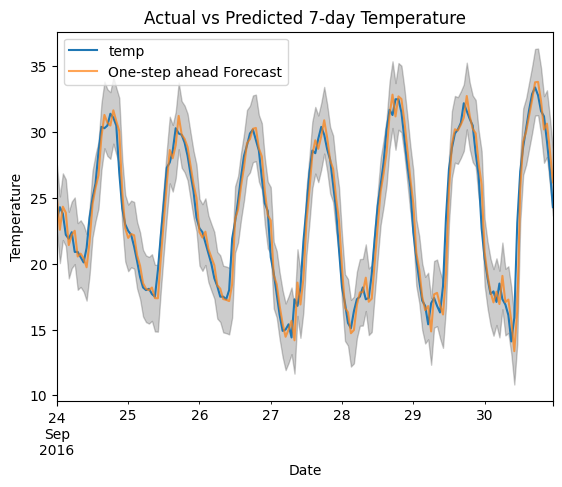

In [13]:
# Visualizing the forecast
ax = sacramento_temp['2016-09-24 00:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_conf_i.index, pred_conf_i.iloc[:,0], pred_conf_i.iloc[:,1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.title('Actual vs Predicted 7-day Temperature')
plt.legend()
plt.show()

The x-axis shows the month, and the y-axis on the left side is in degrees Fahrenheit (°F) for temperature. The y-axis on the right side is in inches for precipitation and in hours for sunshine.

The graph shows that San Diego has a warm Mediterranean climate, with warm, dry summers and mild, wet winters:

**The average high temperature** is highest in August, at around 82°F (28°C), and lowest in December and January, at around 64°F (18°C).

**The average low temperature** is highest in August, at around 68°F (20°C), and lowest in December and January, at around 46°F (8°C).

**San Diego receives most of its rain** during the winter months. The average monthly precipitation is highest in February, at around 2.5 inches (6.3 cm), and lowest in July and August, at around 0.1 inches (0.25 cm).

**San Diego gets the most sunshine hours** in the summer months. The average monthly sunshine is highest in July, at around 11 hours, and lowest in December, at around 7 hours.

#### Calculating Errors

In [14]:
mse = mean_squared_error(y_truth['temp'], y_truth['Pred_temp'])
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 1.7130175725478254
Root Mean Squared Error: 1.3088229721959441


### Future Predictions

In [31]:
pred_future =  results.get_forecast(steps=168)        # Predicting 7 days ahead in the future
pred_conf_i = pred_future.conf_int()                  # Confidence interval of the forecasts

# Storing the predicted future values
future_df = pd.DataFrame(pred_future.predicted_mean)
future_df.columns = ['future_pred']

In [33]:
future_df

,future_pred
2016-10-01 00:00:00,22.788928
2016-10-01 01:00:00,21.830798
2016-10-01 02:00:00,21.433514
2016-10-01 03:00:00,21.108009
2016-10-01 04:00:00,21.132989
...,...
2016-10-07 19:00:00,22.045630
2016-10-07 20:00:00,22.184078
2016-10-07 21:00:00,22.092586
2016-10-07 22:00:00,22.135487


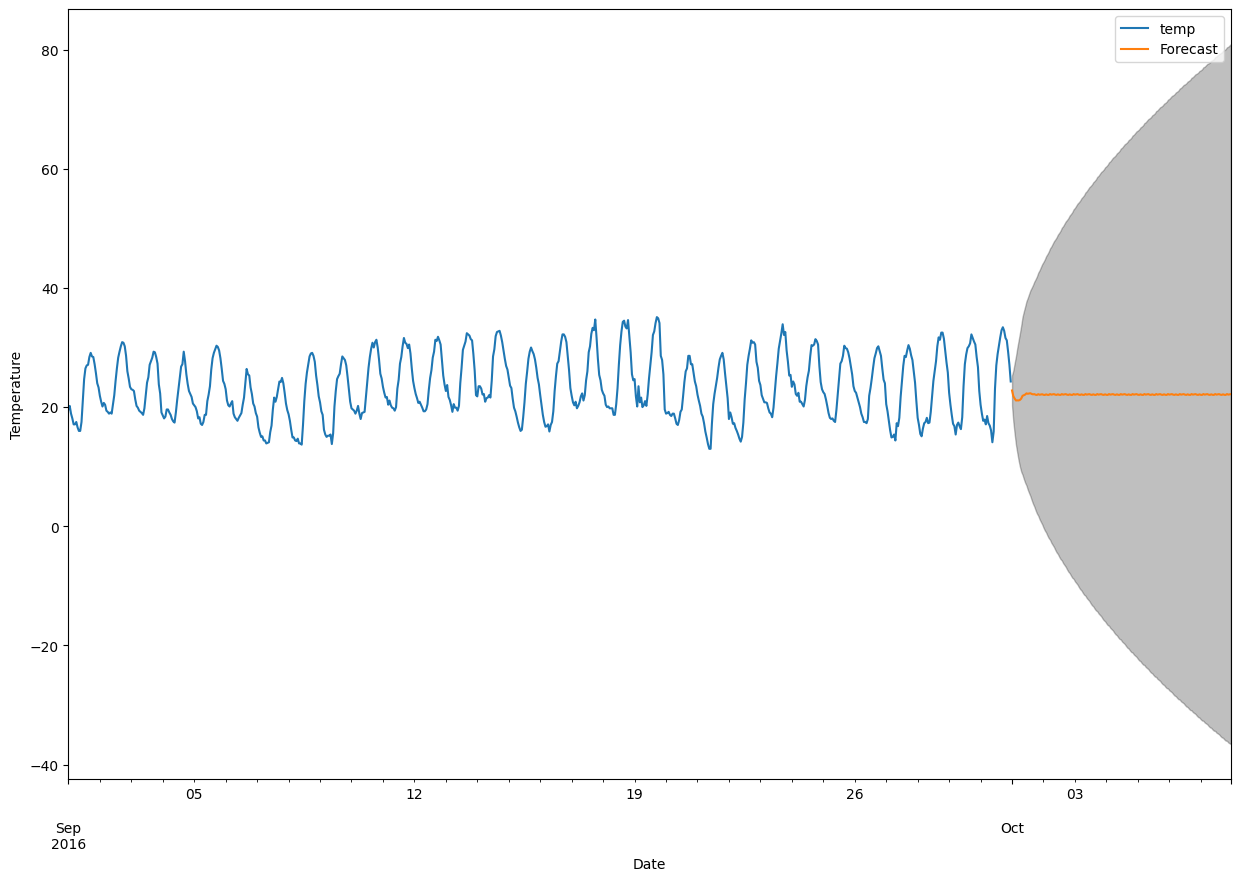

In [22]:
# Filter data for September
sacramento_temp_sept = sacramento_temp[sacramento_temp.index.month == 9]

# Visualizing the predictions 7 days ahead for September
ax = sacramento_temp_sept.plot(label='Observed', figsize=(15,10))
pred_future.predicted_mean.plot(ax=ax, label='Forecast')

# Assuming pred_conf_i is also filtered for September
ax.fill_between(pred_conf_i.index, pred_conf_i.iloc[:,0], pred_conf_i.iloc[:,1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()


## <span style="color:Orange;"> VI. Deep Learning Model </span>  <a name="dl"></a>  
We implement deep learning models for temperature prediction and compare their performance with the ARIMA model. We'll also include a comparison between the results of the ARIMA model and deep learning models, assessing which model performs better in prediction.

In [38]:
# Reshape the Series into a DataFrame with a single column
sacramento_temp_reshaped = sacramento_temp['temp'].values.reshape(-1, 1)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sacramento_temp_reshaped)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, index=sacramento_temp.index, columns=['scaled_temp'])

In [39]:
# Sequence length and features
time_step = 24                             # Predicting after 24 hours/a day
num_features = 1

In [40]:
scaled_df

,scaled_temp
mdct,
2016-01-01 00:00:00,0.635328
2016-01-01 01:00:00,0.635328
2016-01-01 02:00:00,0.629630
2016-01-01 03:00:00,0.612536
2016-01-01 04:00:00,0.592593
...,...
2016-09-30 19:00:00,0.900285
2016-09-30 20:00:00,0.888889
2016-09-30 21:00:00,0.834758


Preparing data for LSTM input

In [98]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

In [99]:
def create_lstm_dataset(data, time_step=24):
    X = []
    y = []

    for i in range(len(data) - time_step):
        seq = data[i:(i+time_step), 0]
        label = data[i+time_step, 0] 
        X.append(seq)
        y.append(label)

    return np.array(X), np.array(y)

#time_step = 1

train_X, train_y = create_lstm_dataset(train_data)
test_X, test_y = create_lstm_dataset(test_data)

In [100]:
print("Shape of train_X:", train_X.shape)
print("Shape of test_X:", test_X.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_X: (5236, 24)
Shape of test_X: (1292, 24)
Shape of train_y: (5236,)
Shape of test_y: (1292,)


#### Creating LSTM Model
LSTM, a Recurrent Neural Network by Hochreiter and Schmidhuber, is excellent for sequential data like videos or texts. It overcomes the vanishing gradient issue, which is ideal for long-term pattern recognition. Its gated cells help manage and remember information effectively, aiding in video analysis and text comprehension (Lawrence, 2023). It is also used in Time Series Analysis.

<details>
  <summary>Click to see reference</summary>
  [1] Lawrence, S. J. (2023, April 18). What is LSTM? - Introduction to Long Short-Term Memory - Scaler Topics. Scaler Topics. https://www.scaler.com/topics/deep-learning/lstm/
</details>


In [101]:
# Creating the LSTM Model
model = tf.keras.models.Sequential([tf.keras.layers.LSTM(64, activation='linear', input_shape=(time_step, 1), return_sequences=True),
                                   tf.keras.layers.BatchNormalization(),

                                   tf.keras.layers.LSTM(32, activation='linear'),
                                   tf.keras.layers.Dropout(0.2),

                                   tf.keras.layers.Dense(1)
])

In [102]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 1, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,473 (115.13 KB)

 Non-trainable params: 128 (512.00 B)

In [103]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [104]:
# Learning Rate Scheduler
initial_learning_rate = 0.01

def lr_schedule(epoch):
    learning_rate = initial_learning_rate
    if epoch > 10:
        learning_rate = initial_learning_rate / 10
    if epoch > 20:
        learning_rate = initial_learning_rate / 100
    return learning_rate

lr_callback = LearningRateScheduler(lr_schedule)

In [105]:
history = model.fit(train_X, train_y, epochs=50, callbacks=[lr_callback, early_stopping], validation_data=(test_X, test_y), validation_split=0.2, verbose=2)

Epoch 1/50
164/164 - 8s - 51ms/step - loss: 0.0643 - mean_absolute_error: 0.1551 - val_loss: 0.0607 - val_mean_absolute_error: 0.2120 - learning_rate: 0.0100
Epoch 2/50
164/164 - 2s - 15ms/step - loss: 0.0216 - mean_absolute_error: 0.1173 - val_loss: 0.0415 - val_mean_absolute_error: 0.1687 - learning_rate: 0.0100
Epoch 3/50
164/164 - 2s - 14ms/step - loss: 0.0206 - mean_absolute_error: 0.1139 - val_loss: 0.0299 - val_mean_absolute_error: 0.1395 - learning_rate: 0.0100
Epoch 4/50
164/164 - 2s - 15ms/step - loss: 0.0198 - mean_absolute_error: 0.1116 - val_loss: 0.0194 - val_mean_absolute_error: 0.1109 - learning_rate: 0.0100
Epoch 5/50
164/164 - 2s - 15ms/step - loss: 0.0195 - mean_absolute_error: 0.1113 - val_loss: 0.0193 - val_mean_absolute_error: 0.1108 - learning_rate: 0.0100
Epoch 6/50
164/164 - 2s - 15ms/step - loss: 0.0192 - mean_absolute_error: 0.1103 - val_loss: 0.0193 - val_mean_absolute_error: 0.1107 - learning_rate: 0.0100
Epoch 7/50
164/164 - 2s - 15ms/step - loss: 0.0190 -

#### Evaluating the Model

In [106]:
# y_true values
test_y_copy = np.repeat(test_y.reshape(-1,1), test_X.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copy)[:,0]

# Predicted values
prediction = model.predict(test_X)
prediction_copies = np.repeat(prediction, 1, axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,0]

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [107]:
predicted_temp

array([21.810572, 21.744251, 21.689215, ..., 21.665173, 21.55752 ,
       21.627321], dtype=float32)

MSE and RMSE

In [122]:
test_y_dl = test_y.reshape(-1, 1)
true_y_dl = scaler.inverse_transform(test_y_dl)

In [125]:
true_y_dl = true_y_dl.reshape(-1)
mse_dl = mean_squared_error(true_y_dl, predicted_temp)
rmse_dl = np.sqrt(mse)

print("Mean Squared Error:", mse_dl)
print("Root Mean Squared Error:", rmse_dl)

Mean Squared Error: 23.721133820307326
Root Mean Squared Error: 1.3088229721959441


#### Forecasting Values

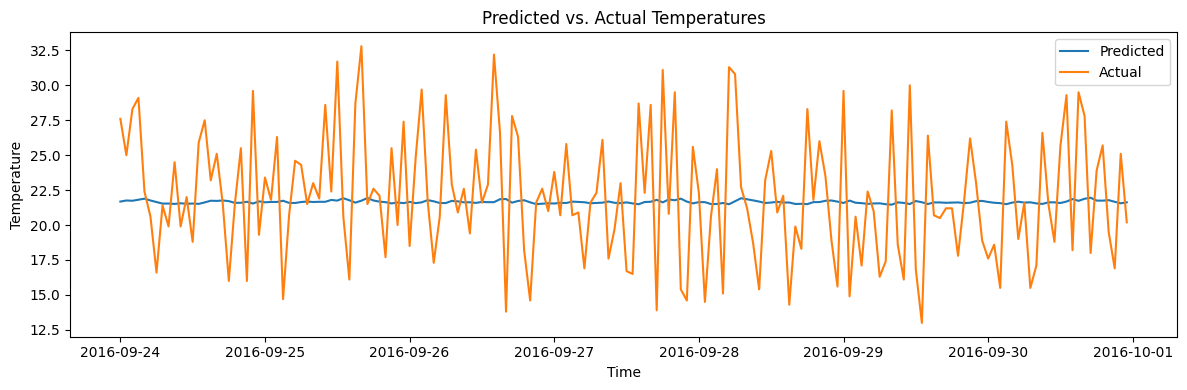

In [108]:
# Plotting predicted and actual temperatures from the past 7 days
plt.figure(figsize=(12,4))
plt.plot(sacramento_temp.index[-168:], predicted_temp[-168:], label='Predicted')
plt.plot(sacramento_temp.index[-168:], true_temp[-168:], label='Actual')
plt.title('Predicted vs. Actual Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()

## <span style="color:Orange;"> VII. Comparison </span>  <a name="comparison"></a>  
The two graphs show how the **LSTM** and **ARIMA models** mean squared errors (MSE) and root mean squared errors (RMSE) differ. The labels "Model" and "Error" are on the x and y-axes of the graphs, respectively. The RMSE of the LSTM and ARIMA models is displayed in the graph on the left. In comparison to the LSTM model, the ARIMA model has a smaller root mean square error. The MSE of the LSTM and ARIMA models is displayed on the right graph. When compared to the LSTM model, the ARIMA model's MSE is smaller. All things considered, the RMSE and MSE of the ARIMA model are lower than those of the LSTM. This observation implies that the ARIMA model outperforms the LSTM model in terms of data fitting.

Additional details:
- The y-axis of the left graph ranges from 0 to 1.4, while the y-axis of the right graph ranges from 0 to 25.
- The graph titles are centered above the corresponding graphs.
- The x-axis labels for the ARIMA and LSTM models are centered below the x-axis.

(Limitations: The observations above may not hold true in some case due to the incomplete feature engineering or fitting of the model in Deep Learning model)


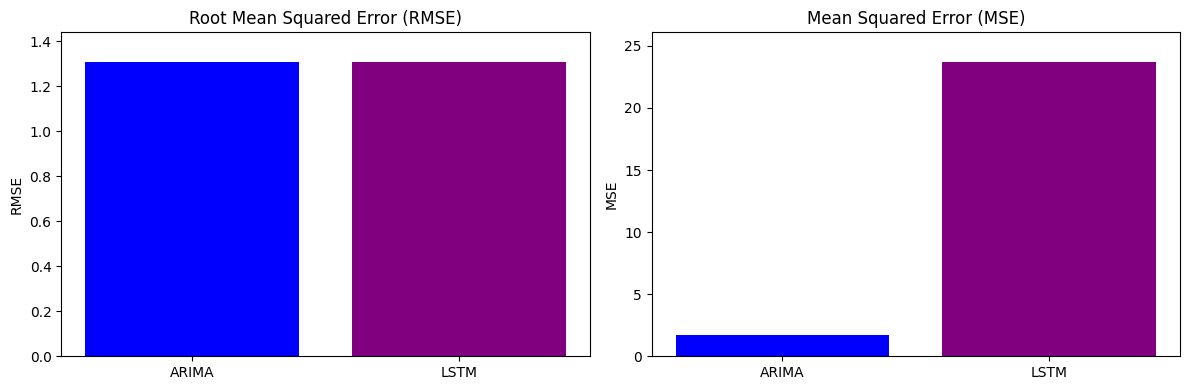

In [128]:
# Bar plot
models = ['ARIMA', 'LSTM']
rmse_values = [rmse, rmse_dl]
mse_values = [mse, mse_dl]

plt.figure(figsize=(12, 4))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['blue', 'purple'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) * 1.1)

# Plot MSE
plt.subplot(1, 2, 2)
plt.bar(models, mse_values, color=['blue', 'purple'])
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.ylim(0, max(mse_values) * 1.1)

plt.tight_layout()
plt.show()

## <span style="color:Orange;"> VIII. Conclusion and Recommendation </span> <a name="conclusion"></a>  
In summary our research shows that both conventional time series modelling approaches like ARIMA and cutting-edge deep learning techniques like LSTM are effective in forecasting temperature. The LSTM model may capture complex temporal patterns and dependencies, but with slightly larger errors than the ARIMA model, which is more straightforward, interpreted, and performs well in short-term predictions. Specific forecasting objectives, data characteristics and the intended balance between accuracy and complexity should all be taken into consideration when selecting one of these models.

Understanding the inherent unpredictability and uncertainty in weather forecasting activities is crucial. As a result, even while models offer insightful information, decision-makers should consider them to be instruments rather than final forecasters of future events. In order to improve forecast accuracy and robustness and eventually empower stakeholders to make informed decisions in a variety of sectors dependent on weather-related information, it is imperative that forecasting methodologies undergo ongoing examination, improvement, and adaptation.


 We recommend the following:

**Utilization of ARIMA for Short-Term Forecasting**: For short-term temperature forecasting tasks, particularly those requiring interpretable results and high accuracy, the ARIMA model is recommended. Its simplicity and effectiveness make it well-suited for applications where understanding the underlying time series dynamics is crucial.

**Exploration of LSTM Model Enhancements**: Despite its higher RMSE, the LSTM model shows promise for temperature prediction tasks. We recommend further exploration of LSTM model enhancements, including fine-tuning hyperparameters, adjusting architecture, and incorporating additional features, to improve its predictive performance.

**Integration of Hybrid Models**: Consideration should be given to integrating hybrid models that combine the strengths of both ARIMA and LSTM. Ensemble techniques or hybrid architectures could potentially leverage the interpretability of ARIMA and the learning capacity of LSTM to achieve more robust and accurate predictions.

**Continuous Model Monitoring and Evaluation**: Regardless of the chosen model, continuous monitoring and evaluation are essential. Regularly assessing model performance against new data ensures that the chosen model remains effective and relevant over time, allowing for timely adjustments and improvements as needed.

By following these recommendations and adopting a holistic approach to model selection and refinement, stakeholders can make informed decisions regarding temperature prediction in Sacramento, ultimately enhancing preparedness and decision-making in various domains impacted by weather fluctuations.
